In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

warnings.filterwarnings("ignore")

## Load data

In [19]:
bank = pd.read_csv(
    'https://raw.githubusercontent.com/tianqi72/BankChurners/main/BankChurners.csv')

# Remove two columns that leaks information
bank = bank.drop(columns=bank.columns[-2:], axis=1)
# Remove id column
bank = bank.drop(columns='CLIENTNUM', axis=1)

print('Shape:', bank.shape)

# Target
y = bank['Attrition_Flag']
X = bank.drop('Attrition_Flag', axis=1)
y = y.values.ravel()

bank.head(1)

Shape: (10127, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061


## EDA

In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [4]:
bank.describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [5]:
# The target is imbalanced. Only 16% customers are attrited.
imbalanced_target = pd.DataFrame(bank['Attrition_Flag'].value_counts())
imbalanced_target

,Attrition_Flag
Existing Customer,8500
Attrited Customer,1627


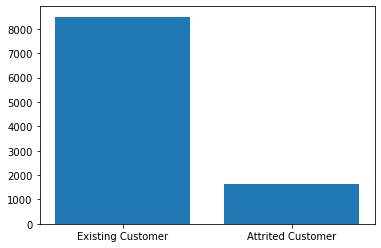

In [6]:
plt.bar(imbalanced_target.index, imbalanced_target['Attrition_Flag'])
plt.show()

## Encode the targets

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)

## Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y)

## Preoprocessing

In [9]:
# Impute missing values
# Standardize numerical variables
con_pipe = Pipeline([('scaler', StandardScaler()),
                     ('imputer', SimpleImputer(strategy='median',
                                               add_indicator=True))])
# Encode categorical variables
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                     ('imputer', SimpleImputer(strategy='most_frequent',
                                               add_indicator=True))])

categorical_columns = (X.dtypes == object)
preprocessing = ColumnTransformer([('categorical', cat_pipe,
                                    categorical_columns),
                                   ('continuous',  con_pipe,
                                    ~categorical_columns)])

# Resampling
smote = SMOTE()

## Hyperparameter tuning

In [10]:
rf_pipe = make_pipeline(preprocessing,
                        smote,
                        RandomForestClassifier(n_jobs=-1))

knn_pipe = make_pipeline(preprocessing,
                         smote,
                         KNeighborsClassifier(n_jobs=-1))

knn_pipe = make_pipeline(preprocessing,
                         smote,
                         KNeighborsClassifier(n_jobs=-1))

svc_pipe = make_pipeline(preprocessing,
                         smote,
                         SVC())

xgb_pipe = make_pipeline(preprocessing,
                         smote,
                         XGBClassifier())

rf_hyper = dict(smote__sampling_strategy=[*np.arange(0.1, 0.5, 0.1), 'auto'],
                smote__k_neighbors=range(2, 20),
                randomforestclassifier__n_estimators=[
                    *range(5, 100, 5), *range(100, 500, 100)],
                randomforestclassifier__max_depth=[*range(2, 30), None],
                randomforestclassifier__min_samples_split=range(1, 10),
                randomforestclassifier__min_samples_leaf=range(1, 10),
                randomforestclassifier__max_features=['auto', 'sqrt', 'log2'],
                randomforestclassifier__class_weight=[None, 'balanced'])

knn_hyper = dict(smote__sampling_strategy=[0.1, 0.2, 0.3, 0.4, 0.5, 'auto'],
                 smote__k_neighbors=range(2, 20),
                 kneighborsclassifier__n_neighbors=range(2, 20),
                 kneighborsclassifier__leaf_size=range(5, 51, 5),
                 kneighborsclassifier__weights=['uniform', 'distance'])

svc_hyper = dict(smote__sampling_strategy=[*np.arange(0.1, 0.5, 0.1), 'auto'],
                 smote__k_neighbors=range(2, 20),
                 svc__C=[0.1, 0.3, 0.5, 1, 10, 50, 100],
                 svc__kernel=['linear', 'poly',
                              'rbf', 'sigmoid', 'precomputed'],
                 svc__gamma=['scale', 'auto'],
                 svc__degree=range(2, 5),
                 svc__class_weight=[None, 'balanced'])

xgb_hyper = dict(smote__sampling_strategy=[*np.arange(0.1, 0.5, 0.1), 'auto'],
                 smote__k_neighbors=range(2, 20),
                 xgbclassifier__booster=['gbtree', 'gblinear', 'dart'],
                 xgbclassifier__eta=np.arange(0, 1, 0.1),
                 xgbclassifier__gamma=range(0, 10),
                 xgbclassifier__max_depth=range(2, 30),
                 xgbclassifier__subsample=np.arange(0.2, 1, 0.1),
                 xgbclassifier__sampling_method=['uniform', 'gradient_based'])

algorithms = [rf_pipe, knn_pipe, svc_pipe, xgb_pipe]
hypers = [rf_hyper, knn_hyper, svc_hyper, xgb_hyper]
algo_name = ['Random Forest', 'KNN', 'SVC', 'XGB']

for algorithm, hyper, name in zip(algorithms, hypers, algo_name):
    clf_rand_cv = RandomizedSearchCV(estimator=algorithm,
                                     param_distributions=hyper,
                                     n_iter=50,
                                     cv=10,
                                     scoring='f1',
                                     n_jobs=-1,
                                     verbose=False)
    clf_rand_cv.fit(X_train, y_train)
    print(f'Best hyperparameters for {name}:')
    print(clf_rand_cv.best_params_, end='\n\n')

Best hyperparameters for Random Forest:
{'smote__sampling_strategy': 0.4, 'smote__k_neighbors': 12, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__class_weight': 'balanced'}

Best hyperparameters for KNN:
{'smote__sampling_strategy': 0.2, 'smote__k_neighbors': 11, 'kneighborsclassifier__weights': 'uniform', 'kneighborsclassifier__n_neighbors': 10, 'kneighborsclassifier__leaf_size': 10}

Best hyperparameters for SVC:
{'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__degree': 2, 'svc__class_weight': None, 'svc__C': 50, 'smote__sampling_strategy': 0.4, 'smote__k_neighbors': 2}

[01:26:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'loglos

## Model selection

In [12]:
rf_pipe = make_pipeline(preprocessing,
                        SMOTE(sampling_strategy=0.4, k_neighbors=12),
                        RandomForestClassifier(n_estimators=100,
                                               min_samples_split=8,
                                               min_samples_leaf=2,
                                               max_features='sqrt',
                                               max_depth=None,
                                               class_weight='balanced',
                                               n_jobs=-1))

knn_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.3,
                               k_neighbors=11),
                         KNeighborsClassifier(weights='uniform',
                                              n_neighbors=10,
                                              leaf_size=10,
                                              n_jobs=-1))

svc_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.4, k_neighbors=2),
                         SVC(kernel='rbf',
                             gamma='auto',
                             degree=2,
                             C=50))

xgb_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.4, k_neighbors=15),
                         XGBClassifier(subsample=0.5,
                                       sampling_method='uniform',
                                       max_depth=3,
                                       gamma=5,
                                       eta=0.5,
                                       booster='gbtree'))

algorithms = [rf_pipe, knn_pipe, svc_pipe, xgb_pipe]
results = []
for pipe, name in zip(algorithms, algo_name):
    score = cross_val_score(pipe, X_train, y_train, cv=5,
                            scoring='f1_weighted', n_jobs=-1)
    results.append(score)
    print(name, round(np.mean(score), 4))

Random Forest 0.9529
KNN 0.9105
SVC 0.9289
XGB 0.9679


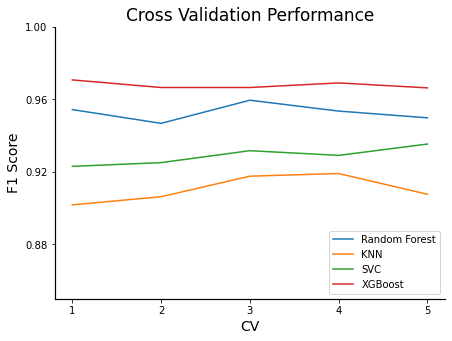

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
x = [1, 2, 3, 4, 5]
ax.plot(x, results[0], label="Random Forest")
ax.plot(x, results[1], label="KNN")
ax.plot(x, results[2], label="SVC")
ax.plot(x, results[3], label="XGBoost")
plt.ylim(0.85, 1)
ax.set_yticks([0.88, 0.92, 0.96, 1])
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title("Cross Validation Performance", size=17)
ax.set_xlabel("CV", size=14)
ax.set_ylabel("F1 Score", size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
plt.legend(loc='lower right')
plt.show()

## Final model evaluation

In [16]:
xgb_pipe = make_pipeline(preprocessing,
                         SMOTE(sampling_strategy=0.2,
                               k_neighbors=3),
                         XGBClassifier(subsample=0.6,
                                       sampling_method='uniform',
                                       max_depth=10,
                                       gamma=3,
                                       eta=0.2,
                                       booster='gbtree'))
xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[01:29:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9708785784797631
F1 Score: 0.9826623567440493
Confusion Matrix:
[[ 295   30]
 [  29 1672]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       325
           1       0.98      0.98      0.98      1701

    accuracy                           0.97      2026
   macro avg       0.95      0.95      0.95      2026
weighted avg       0.97      0.97      0.97      2026

